# Spectra compare

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.ticker import FuncFormatter
from ipywidgets import interactive_output, Dropdown, IntRangeSlider, ToggleButton, Text, VBox
from glob import glob

plt.style.use('seaborn-whitegrid')

## Set variables

In [2]:
EPOCH = '20d'  # Select one epoch per run

In [3]:
fnames = sorted(glob('output/{}/*.h5'.format(EPOCH)))

## Define functions

In [4]:
def make_plot_data(fname):
    
    keys = pd.HDFStore(fname, mode='r').keys()
    data = {k.strip('/'):pd.read_hdf(fname, k) for k in keys} 
    
    return data

In [5]:
# This looks ugly
make_labels = lambda x: x.rstrip('.h5').lstrip('output/').replace('_cd23_latest','')\
                            .replace('chianti', '& Chianti').replace('kurucz', 'Kurucz')\
                                .replace('_', ' ').replace('20d', '').replace('15d', '')\
                                    .replace('10d', '').replace('5d', '').replace('0', 'I')\
                                        .replace('1', 'II').replace('2', 'III').replace('I ', 'I, ')\
                                            .rstrip(', ').lstrip('/').replace('all', '(all)') + ' '

In [6]:
sci_format = lambda x, lim: '0' if x == 0 else '{:.0e}'.format(x)

major_formatter = FuncFormatter(sci_format)

In [7]:
def compare_spectra(file_1, file_2, xrange, savefig=False, output='Snapshot.png'):
    
    data_1 = make_plot_data(file_1)
    data_2 = make_plot_data(file_2)

    fig = plt.figure(figsize=(9, 7))
    gs = gridspec.GridSpec(2, 1, height_ratios=[5, 1.6], hspace=0.05)
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])
    
    label_1 = make_labels(file_1)
    label_2 = make_labels(file_2)

    ax0.plot(data_1['wavelength'], data_1['luminosity_density_lambda'], label=label_1)
    ax0.plot(data_2['wavelength'], data_2['luminosity_density_lambda'], label=label_2)
    ax0.set_xlim(xrange[0], xrange[-1])
    ax0.set_xticklabels([])
    ax0.yaxis.set_major_formatter(major_formatter)
    ax0.set_ylabel(r'Luminosity  [ $\mathrm{erg} \mathrm{s}^{−1} \mathrm{A}^{−1}}$ ]')
    ax0.legend(frameon=True, handlelength=1.5)
    residual = 100*(data_2['luminosity_density_lambda']-data_1['luminosity_density_lambda'])\
                    /data_1['luminosity_density_lambda']
    ax1.plot(data_1['wavelength'], residual, color='C2')
    ax1.set_xlim(xrange[0], xrange[-1])
    
    idx1 = (np.abs(data_1['wavelength'] - xrange[0])).idxmin()
    idx2 = (np.abs(data_1['wavelength'] - xrange[-1])).idxmin()
    
    if idx1 < idx2:
        ylim_bottom = residual[idx1:idx2].min()
        ylim_top = residual[idx1:idx2].max()
        
    else:
        ylim_bottom = residual[idx2:idx1].min()
        ylim_top = residual[idx2:idx1].max()
        
    
    ax1.set_ylim(ylim_bottom, ylim_top)
    ax1.set_xlabel('Wavelength  [ $\mathrm{\AA}$ ]', labelpad=10)
    ax1.set_ylabel('Residual (%)')
    #ax1.ticklabel_format(axis='x', style='sci', scilimits=(3,3))
    ax1.tick_params(axis='x', pad=5)

    fig.align_ylabels([ax0, ax1])
    
    # Save to PDF if `pdf` buffer is passed via context manager
    try:
        pdf.savefig()
        
    except NameError:
        pass

    # Save to PNG
    if savefig:
        fig.savefig(output)
        
    return

## Interactive display

In [8]:
layout = {'width': '452px'}

dropdown_1 = Dropdown(
    options=fnames,
    description='Storage A:',
    disabled=False,
    layout=layout
)

dropdown_2 = Dropdown(
    options=[i for i in reversed(fnames)],
    description='Storage B:',
    disabled=False,
    layout=layout
)

slider = IntRangeSlider(
    value=[2000, 10000],
    min=500,
    max=20000,
    step=1,
    description='\u03BB:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
    layout=layout
)

In [9]:
ui = VBox([dropdown_1, dropdown_2, slider])

f = interactive_output(compare_spectra, 
                       dict(file_1=dropdown_1, 
                            file_2=dropdown_2, 
                            xrange=slider))

In [10]:
display(ui, f)

Output()

## Save to PNG

In [11]:
def to_png(fname):
    os.makedirs('img/{}'.format(EPOCH), exist_ok=True)
    return fname.replace('output/', 'img/').rstrip('.h5')

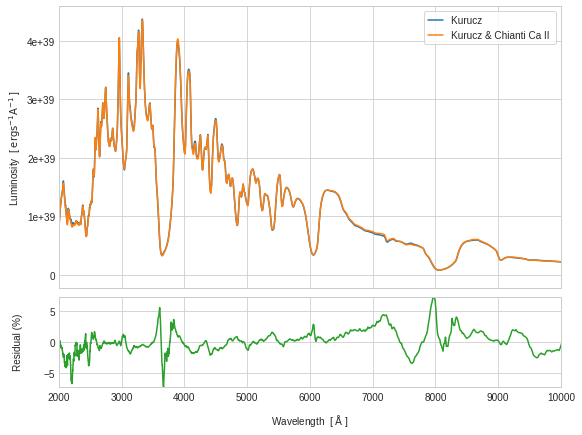

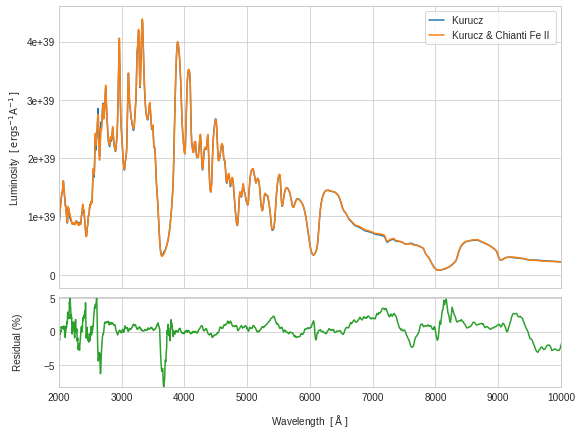

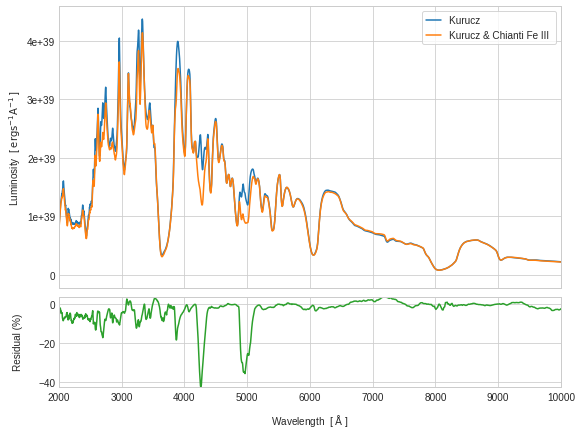

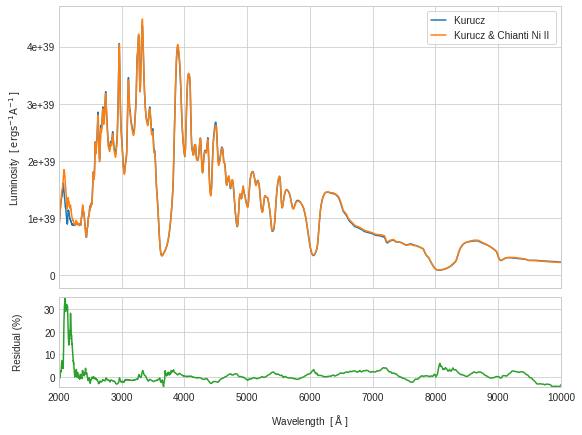

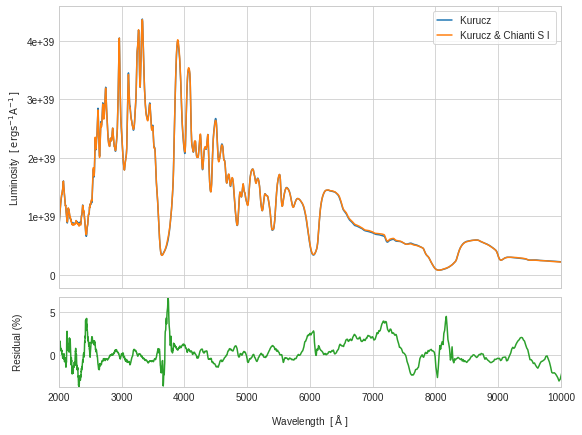

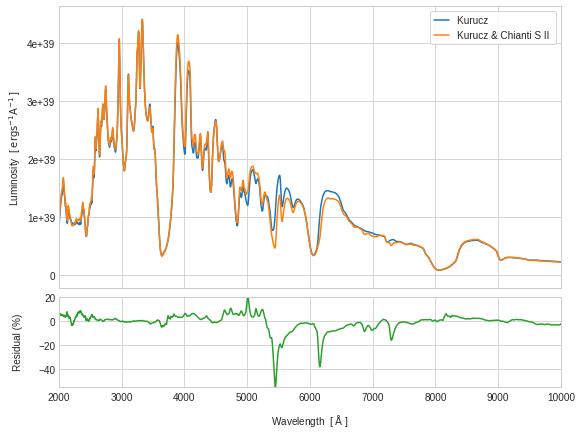

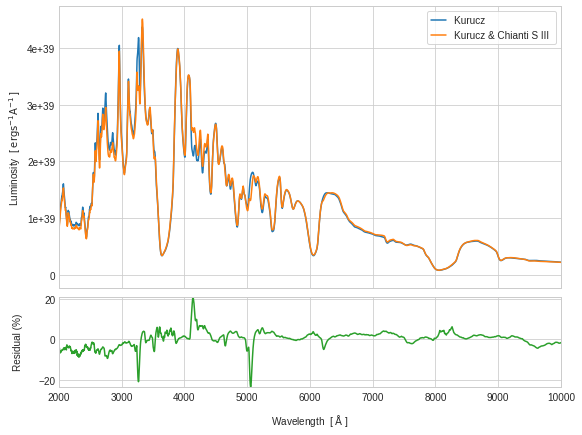

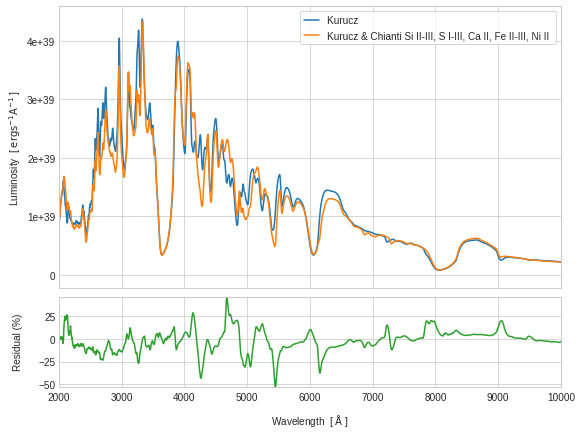

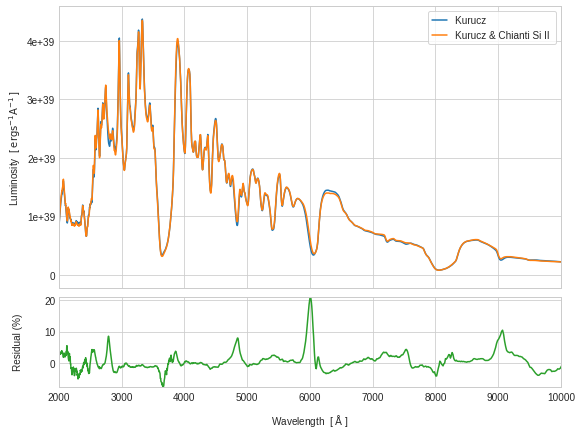

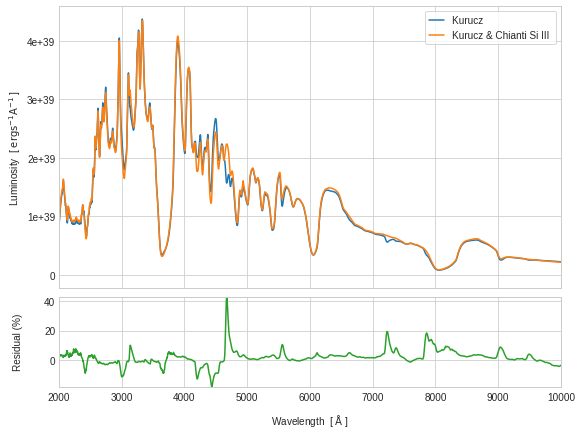

In [12]:
for fname in fnames[1:]:
    _ = compare_spectra('output/{}/kurucz_cd23_latest_{}.h5'.format(EPOCH, EPOCH), 
                        fname, [2000, 10000], savefig=True, output=to_png(fname))

## Save to PDF

In [13]:
from matplotlib.backends.backend_pdf import PdfPages

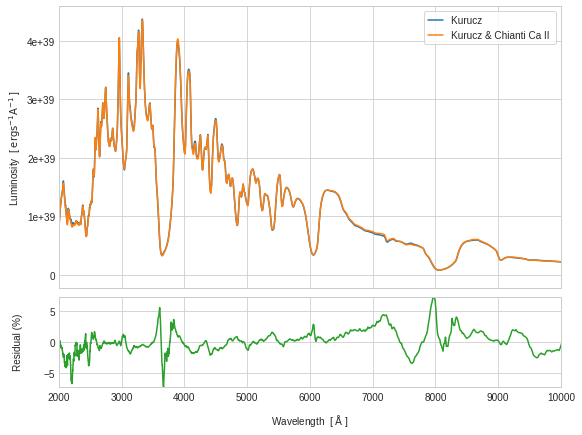

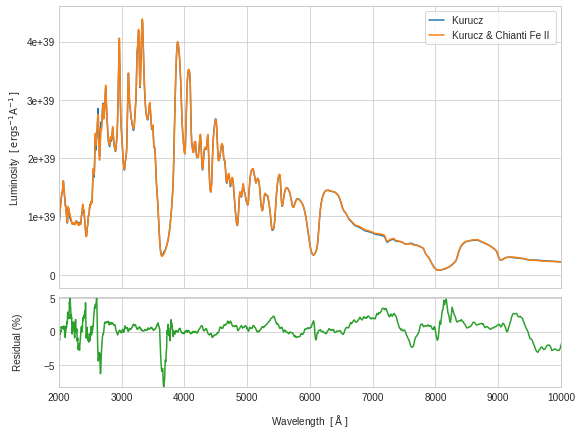

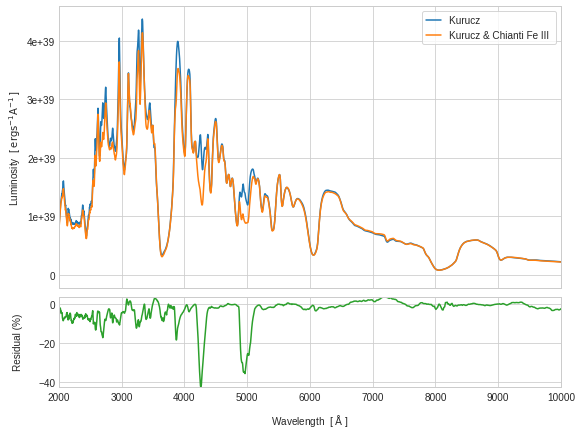

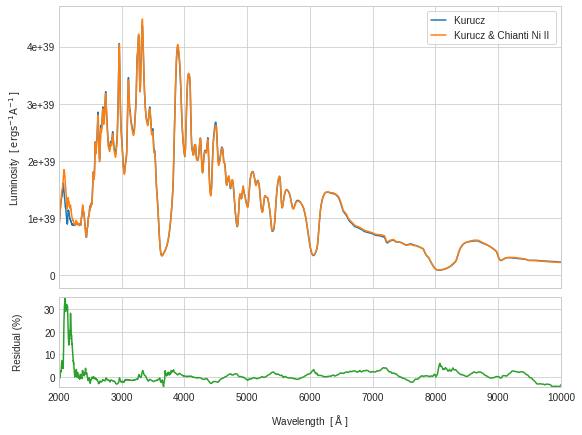

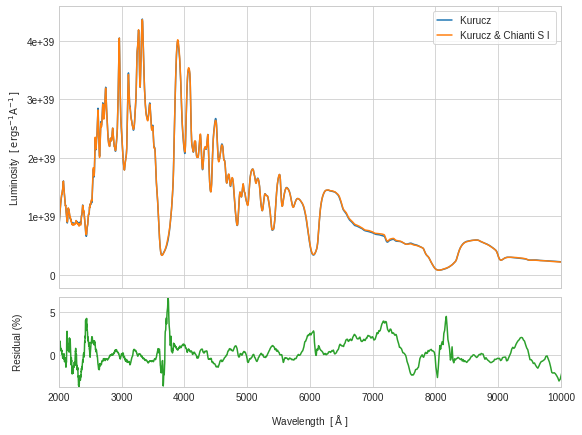

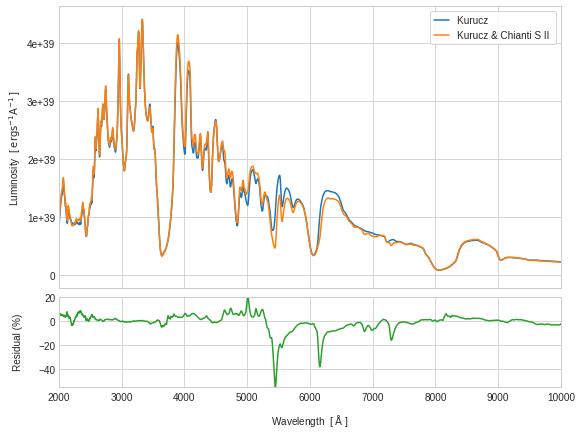

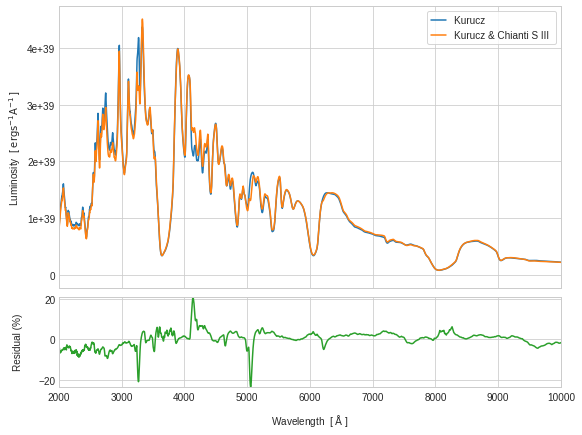

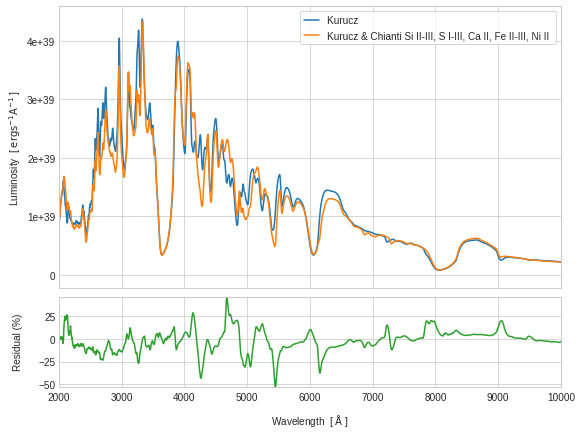

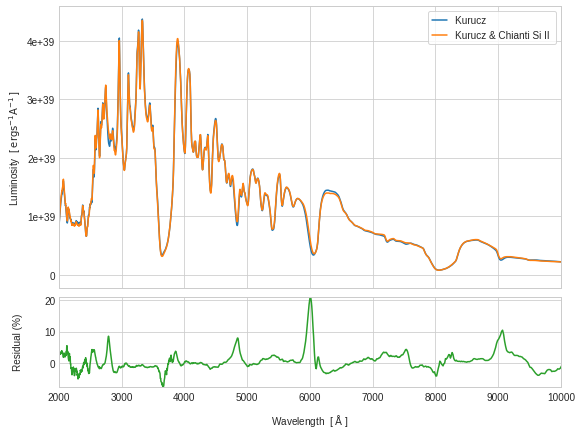

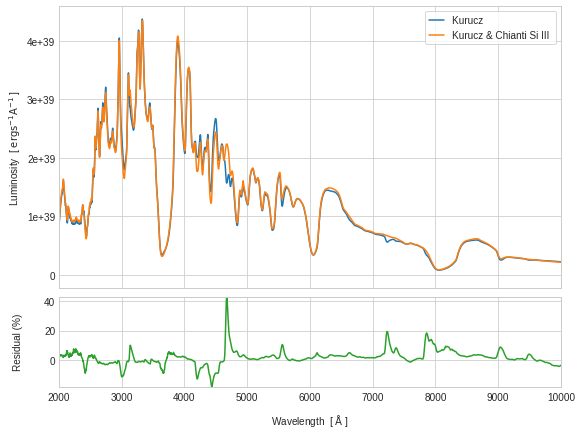

In [14]:
with PdfPages('img/{}.pdf'.format(EPOCH)) as pdf:
    for fname in fnames[1:]:
        _ = compare_spectra('output/{}/kurucz_cd23_latest_{}.h5'.format(EPOCH, EPOCH), 
                            fname, [2000, 10000])

# Remove from namespace
del(pdf)